https://github.com/timsainb/tensorflow2-generative-models/blob/master/3.0-WGAN-GP-fashion-mnist.ipynb

In [0]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.0.0-beta1

In [1]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd

print(tf.__version__)

2.0.0-beta1


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
TRAIN_BUF=60000
BATCH_SIZE=256
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)


# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# normalizing and reshaping dataset
# (m,28,28) to (m,28,28,1)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
class WGAN(tf.keras.Model):
    """
    Extends tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)
      
    
    def compute_loss_critic(self, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x_gen)  #
            - tf.reduce_mean(logits_x)
            + d_regularizer * self.gradient_penalty_weight
        )
        
        return disc_loss
      
    def compute_loss_generator(self, x):
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])  
        x_gen = self.generate(z_samp)
        logits_x_gen = self.discriminate(x_gen)
        # losses of fake with label "1"
        gen_loss = -tf.reduce_mean(logits_x_gen)
        
        return gen_loss
      

    
    def compute_gradients_critic(self, x):
        
        with tf.GradientTape() as disc_tape:
            disc_loss = self.compute_loss_critic(x)

        # compute gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return disc_gradients
      
    def compute_gradients_generator(self, x):
        
        with tf.GradientTape() as gen_tape:
            gen_loss = self.compute_loss_generator(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        return gen_gradients
      
      

    def apply_gradients_critic(self, disc_gradients):
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
        
    def apply_gradients_generator(self, gen_gradients):
        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
      


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

      

    @tf.function
    def train_new(self, train_x):
      
      for _ in range(self.n_critic):
        disc_gradients = self.compute_gradients_critic(train_x)
        self.apply_gradients_critic(disc_gradients)
      
      gen_gradients = self.compute_gradients_generator(train_x)
      self.apply_gradients_generator(gen_gradients)
      
        
        
#     @tf.function
#     def train(self, train_x):
        
#         gen_gradients, disc_gradients = self.compute_gradients(train_x)
#         self.apply_gradients(gen_gradients, disc_gradients)
        
        
    def sample_images(self, epoch):

        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.n_Z))
        
        gen_imgs = self.generate(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].matshow(
                    gen_imgs[cnt, :,:,0], cmap=plt.cm.Greys, vmin=0, vmax=1
                )
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/img_%d.png" % epoch)
        plt.close()

In [0]:
N_Z = 64

generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
]

In [0]:
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.0, beta_2=0.9) # learning_rate = alpha = 0.0001
disc_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.0, beta_2=0.9)

# gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
# disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)


model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0,
    n_critic = 5
)

In [0]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

n_epochs = 100

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0 | disc_loss: 2.96427 | gen_loss: -0.63134
Epoch: 1 | disc_loss: 0.53667 | gen_loss: -0.66717
Epoch: 2 | disc_loss: -0.43483 | gen_loss: -0.16495
Epoch: 3 | disc_loss: -0.50588 | gen_loss: -0.16273
Epoch: 4 | disc_loss: -0.47581 | gen_loss: -0.29922
Epoch: 5 | disc_loss: -0.27073 | gen_loss: -0.44100
Epoch: 6 | disc_loss: -0.31931 | gen_loss: -0.35594
Epoch: 7 | disc_loss: -0.30380 | gen_loss: -0.36085
Epoch: 8 | disc_loss: -0.29324 | gen_loss: -0.35803
Epoch: 9 | disc_loss: -0.30997 | gen_loss: -0.34674
Epoch: 10 | disc_loss: -0.27112 | gen_loss: -0.37013
Epoch: 11 | disc_loss: -0.25015 | gen_loss: -0.37071
Epoch: 12 | disc_loss: -0.25264 | gen_loss: -0.35971
Epoch: 13 | disc_loss: -0.25164 | gen_loss: -0.36001
Epoch: 14 | disc_loss: -0.24600 | gen_loss: -0.36737
Epoch: 15 | disc_loss: -0.24422 | gen_loss: -0.36606
Epoch: 16 | disc_loss: -0.23187 | gen_loss: -0.37363
Epoch: 17 | disc_

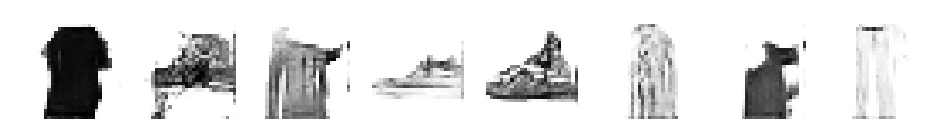

In [9]:
for epoch in range(n_epochs):
  
    loss = []
    for train_x in train_dataset:
        model.train_new(train_x)
        loss.append([model.compute_loss_critic(train_x), model.compute_loss_generator(train_x)])
      
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    print(
        "Epoch: {0} | disc_loss: {1:.5f} | gen_loss: {2:.5f}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    
    sample_interval = 5
    if epoch % sample_interval == 0:
        model.sample_images(epoch)

plot_reconstruction(model)

In [0]:
### it took 65 mins to train!


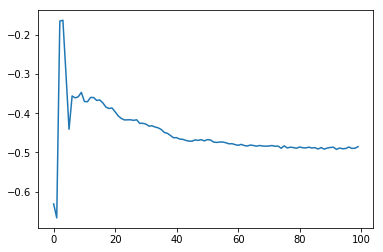

In [10]:
plt.plot(losses.gen_loss.values)

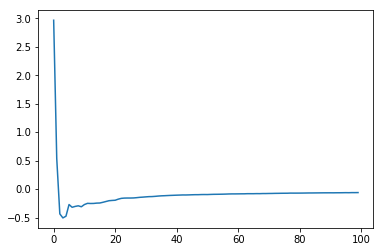

In [11]:
plt.plot(losses.disc_loss.values)

In [0]:
!zip -r /content/file.zip /content/images